In [8]:
import matplotlib.pyplot as plt
import csv
import numpy as np

def read_mlflow_csv(csv_path):
    # headers: run_id,key,value,step,timestamp
    # we are only interested in: acc_top1, acc_top1_train, acc_top1_val for each step (epoch)

    acc_top1_arr, acc_top1_train_arr, acc_top1_val_arr = [], [], []
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            if row[1].strip() == 'acc_top1':
                acc_top1_arr.append(float(row[2]))
            elif row[1].strip() == 'acc_top1_train':
                acc_top1_train_arr.append(float(row[2]))
            elif row[1].strip() == 'acc_top1_val':
                acc_top1_val_arr.append(float(row[2]))
    return acc_top1_train_arr, acc_top1_val_arr, acc_top1_arr, []

def read_tensorboard_csvs(csv_paths):
    # headers: Wall time, Step, Value
    csv_path_arr = csv_paths.split(",")
    acc_arr_arr = []
    for csv_path in csv_path_arr:
        acc_top1_arr = []
        with open(csv_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            next(csv_reader)
            for row in csv_reader:
                acc_top1_arr.append(float(row[2]))
        acc_arr_arr.append(acc_top1_arr)
    return acc_arr_arr

def read_csv(csv_path):
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        train_acc_arr, val_acc_arr, test_acc_arr, train_loss_arr = [], [], [], []
        for row in csv_reader:
            if len(row) < 4:
                break
            train_loss_arr.append(float(row[0]))
            train_acc_arr.append(float(row[1]))
            test_acc_arr.append(float(row[2]))
            val_acc_arr.append(float(row[3]))

    if max(train_acc_arr) < 2:
        train_acc_arr = [acc * 100 for acc in train_acc_arr]
        test_acc_arr = [acc * 100 for acc in test_acc_arr]
        val_acc_arr = [acc * 100 for acc in val_acc_arr]
    return train_acc_arr, val_acc_arr, test_acc_arr, train_loss_arr

def plot_train_val_test_mlflow(title, csv_path, show=False, save_path=None):
    train_acc_arr, val_acc_arr, test_acc_arr, _ = read_mlflow_csv(csv_path)
    epochs = np.arange(1, len(train_acc_arr) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.plot(epochs, train_acc_arr, color='tab:blue', label='Training Accuracy')
    ax1.plot(epochs, val_acc_arr, color='tab:green', label='Validation Accuracy')
    ax1.plot(epochs, test_acc_arr, color='tab:orange', label='Test Accuracy')
    ax1.tick_params(axis='y')

    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='lower left')

    plt.title(title)
    show and plt.show()
    save_path and plt.savefig(save_path)
    return plt


def plot_train_val_test_tensorboard(titles, csv_path, show=False, save_path=None):
    acc_arr_arr = read_tensorboard_csvs(csv_path)
    title_arr = titles.split(",")
    epochs = np.arange(1, len(acc_arr_arr[0]) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='y')

    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='lower left')

    plt.title("SimCLR Contrastive Learning")
    show and plt.show()
    save_path and plt.savefig(save_path)
    return plt

def plot_train_val_test(title, csv_path, show=False, save_path=None):
    if is_mlflow(csv_path):
        return plot_train_val_test_mlflow(title, csv_path, show, save_path)
    if is_tensorboard(csv_path):
        return plot_train_val_test_tensorboard(title, csv_path, show, save_path)
    train_acc_arr, val_acc_arr, test_acc_arr, train_loss_arr = read_csv(csv_path)
    epochs = np.arange(1, len(train_loss_arr) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.plot(epochs, train_acc_arr, color='tab:blue', label='Training Accuracy')
    ax1.plot(epochs, val_acc_arr, color='tab:green', label='Validation Accuracy')
    ax1.plot(epochs, test_acc_arr, color='tab:orange', label='Test Accuracy')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(epochs, train_loss_arr, color=color, label='Training Loss')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower left')

    plt.title(title)
    show and plt.show()
    save_path and plt.savefig(save_path)
    return plt

def is_mlflow(csv_path):
    with open(csv_path, 'r') as csv_file:
        first_line = csv_file.readline()
        if "run_id,key,value,step,timestamp" == first_line.replace("\n", "").replace(" ", ""):
            return True
        return False
    
def is_tensorboard(csv_path):
    return "," in csv_path
    
def get_best_val_test_acc(csv_path):
    _, val_acc_arr, test_acc_arr, _ = read_csv(csv_path) if not is_mlflow(csv_path) else read_mlflow_csv(csv_path)
    # if two val acc are the same with 0.001 precision, choose the one with higher test acc
    best_val_acc = max(val_acc_arr)
    best_val_acc_idxs = [i for i, val_acc in enumerate(val_acc_arr) if abs(val_acc - best_val_acc) < 0.001]

    # get best test acc
    best_test_acc = max([test_acc_arr[i] for i in best_val_acc_idxs])
    best_test_acc_idx = [i for i in best_val_acc_idxs if test_acc_arr[i] == best_test_acc][-1]
    return best_val_acc, best_test_acc, best_test_acc_idx



ResNet18 (no pretraining, batch size 64)		Epoch [38] has the best val acc [54.76190476190476] with test acc [46.93877551020408]
ResNet18 (with pretraining, batch size 64)		Epoch [20] has the best val acc [47.61904761904762] with test acc [48.97959183673469]
SimCLR (frozen, dim 128)		Epoch [61] has the best val acc [57.14285659790039] with test acc [46.93877410888672]
SimCLR (not frozen, dim 128)		Epoch [38] has the best val acc [71.42857360839844] with test acc [61.2244873046875]
SimCLR (dim 256, frozen)		Epoch [99] has the best val acc [59.523807525634766] with test acc [55.1020393371582]
SimCLR (dim 256, not frozen)		Epoch [65] has the best val acc [69.04761505126953] with test acc [59.18367385864258]
SimCLR (ResNet50, dim 128, frozen)		Epoch [112] has the best val acc [66.66666412353516] with test acc [55.1020393371582]
Vision Transformer (configuration 1)		Epoch [46] has the best val acc [34.69387755102041] with test acc [35.714285714285715]
Vision Transformer (configuration 2)		Ep

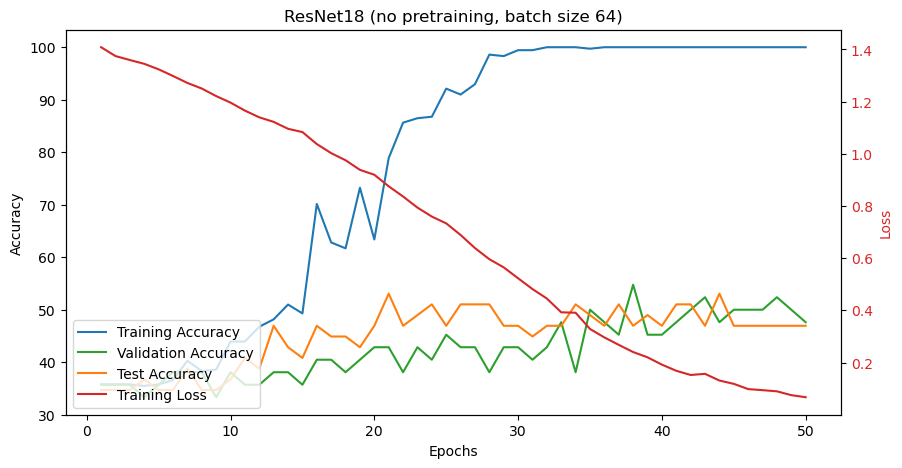

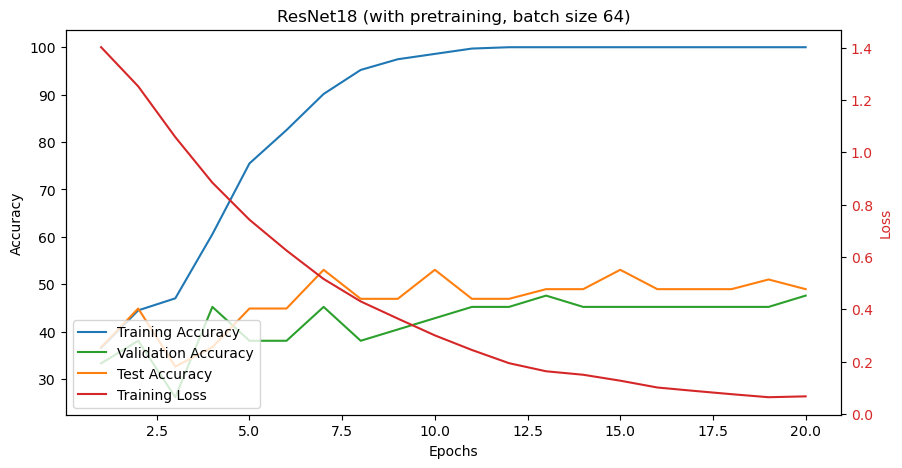

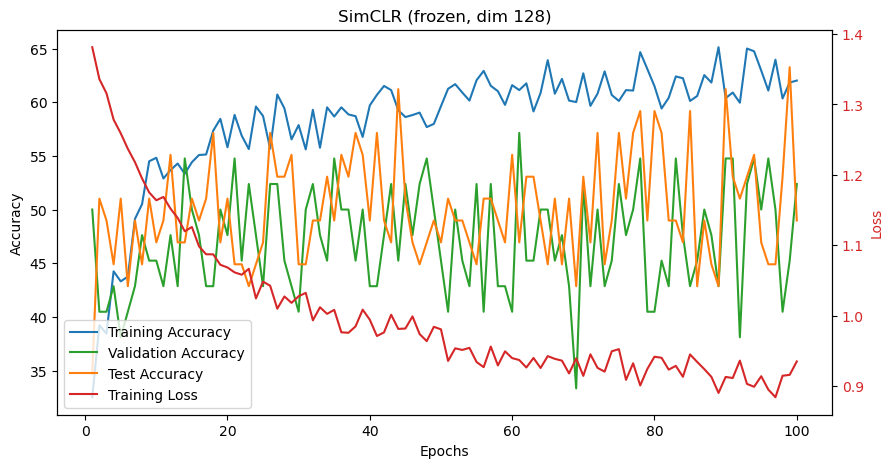

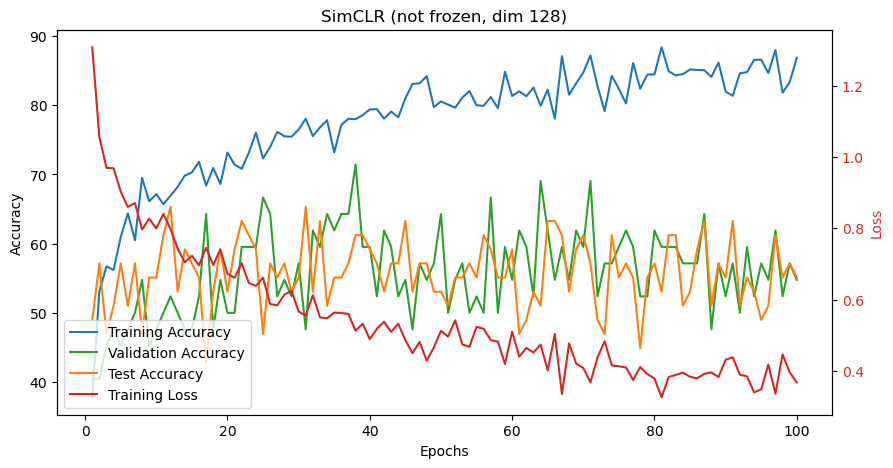

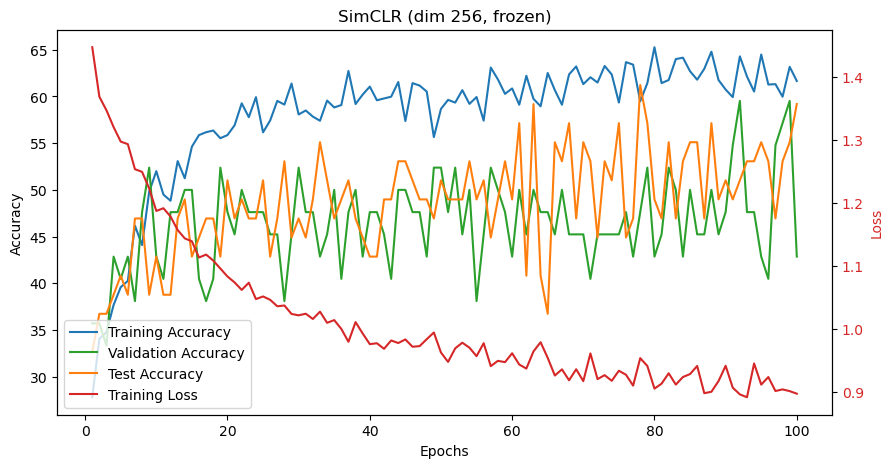

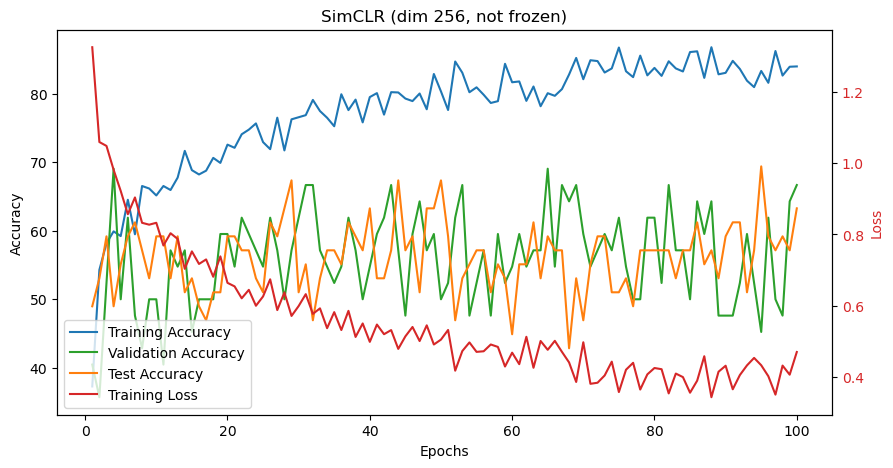

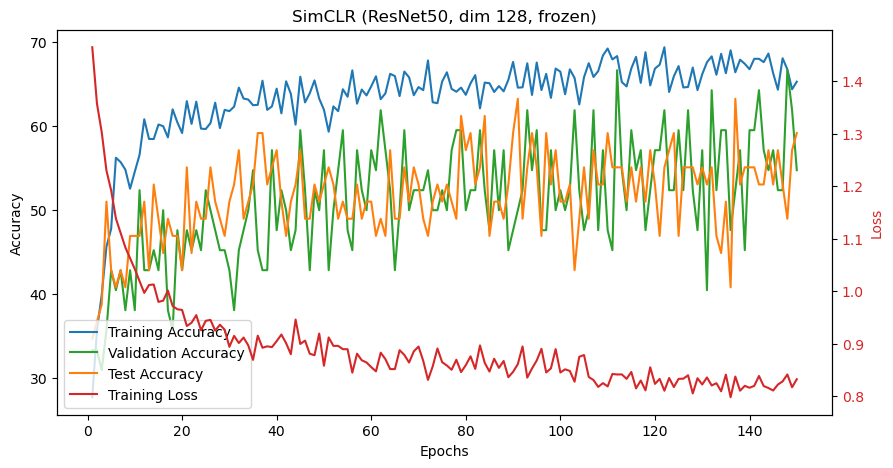

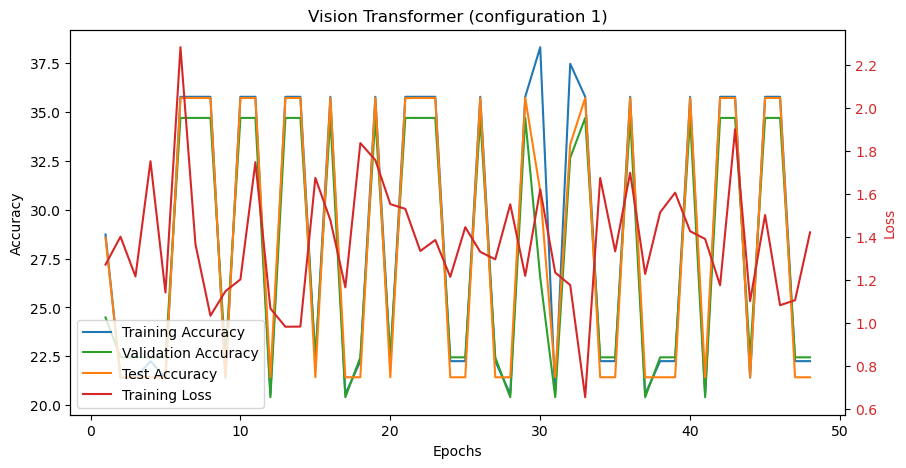

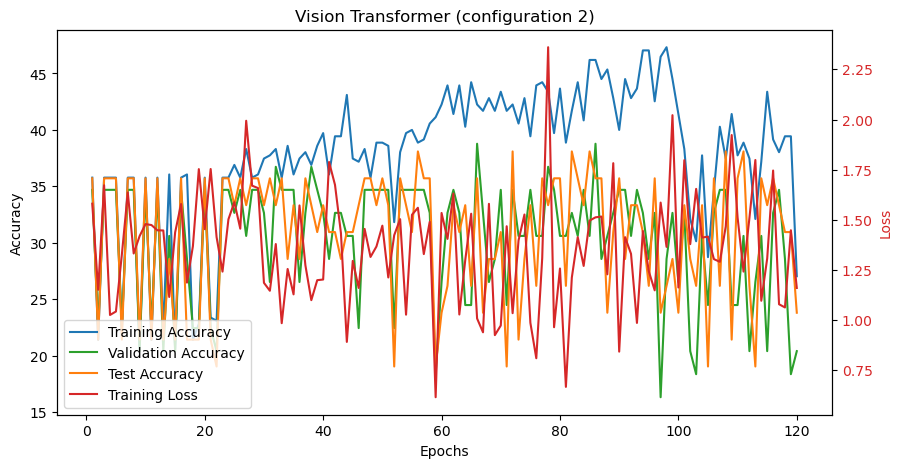

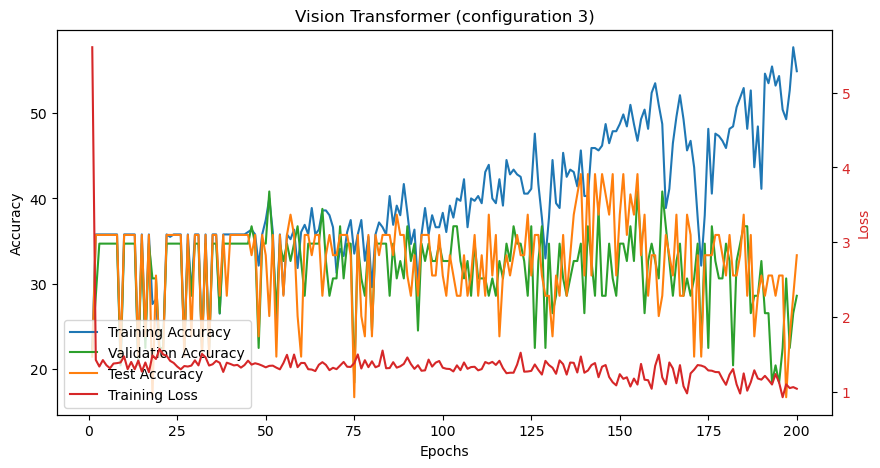

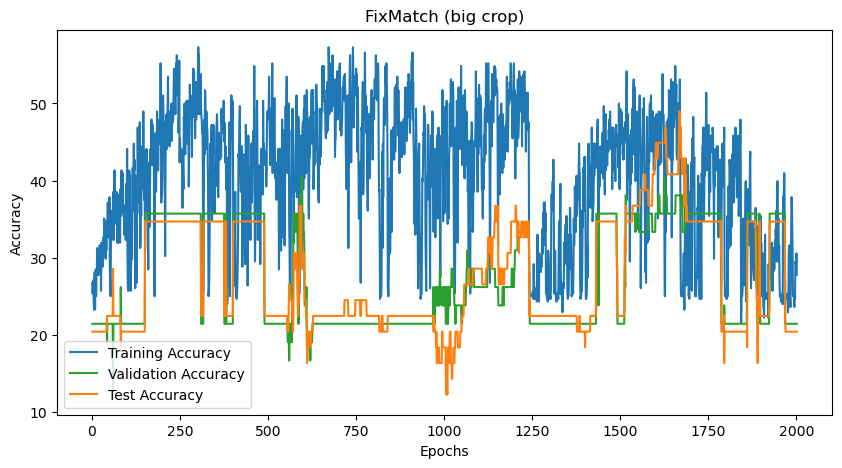

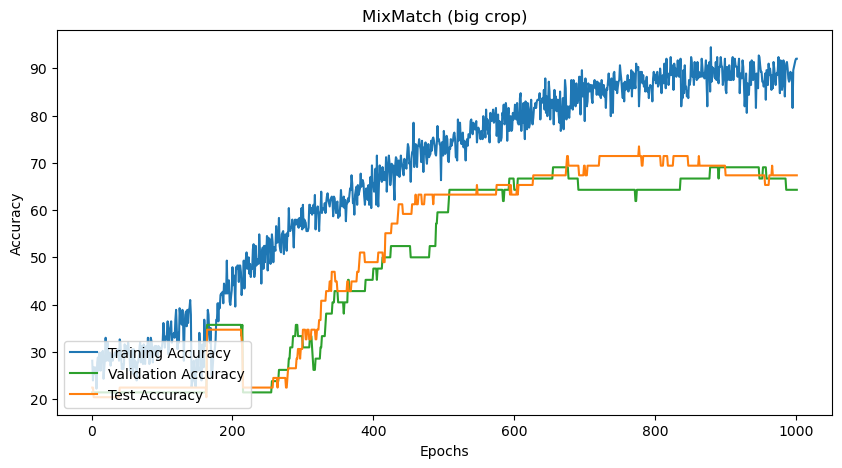

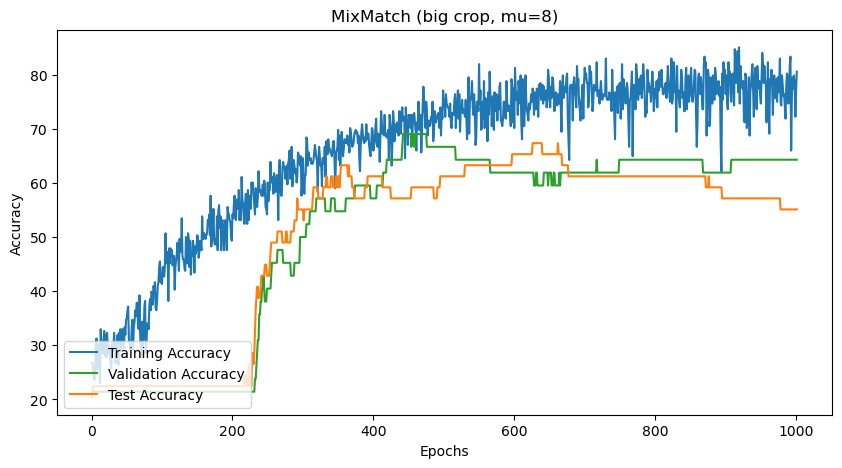

In [10]:
titles = {
    "./resnet/csv/resnet18_batch64_noaug_nopretrain.csv": "ResNet18 (no pretraining, batch size 64)",
    "./resnet/csv/resnet18_batch64_noaug_pretrain.csv": "ResNet18 (with pretraining, batch size 64)",
    "./simclr/feature_eval/csv/simclr_resnet18_dim128_batch256_epoch275_frozen.csv": "SimCLR (frozen, dim 128)",
    "./simclr/feature_eval/csv/simclr_resnet18_dim128_batch256_epoch275_notfrozen.csv": "SimCLR (not frozen, dim 128)",
    "./simclr/feature_eval/csv/simclr_resnet18_dim256_batch256_epoch275_frozen.csv": "SimCLR (dim 256, frozen)",
    "./simclr/feature_eval/csv/simclr_resnet18_dim256_batch256_epoch275_notfrozen.csv": "SimCLR (dim 256, not frozen)",
    "./simclr/feature_eval/csv/simclr_resnet50_dim128_batch200_epoch295_frozen.csv": "SimCLR (ResNet50, dim 128, frozen)",
    "./vision_transformer/train_acc.csv": "Vision Transformer (configuration 1)",
    "./vision_transformer/train_acc_1.csv": "Vision Transformer (configuration 2)",
    "./vision_transformer/train_acc_0.csv": "Vision Transformer (configuration 3)",
    "./mixmatch_fixmatch/csv/fixmatch_bigcrop.csv": "FixMatch (big crop)",
    "./mixmatch_fixmatch/csv/mixmatch_bigcrop.csv": "MixMatch (big crop)",
    "./mixmatch_fixmatch/csv/mixmatch_bigcrop_mu8.csv": "MixMatch (big crop, mu=8)",
}

plot_dir = "./plots/"

for csv_path, title in titles.items():
    save_path = plot_dir + title + ".png"
    plot_train_val_test(title, csv_path, show=False, save_path=save_path)
    print(title + "\t\t", end="")
    best_val_acc, best_test_acc, best_test_acc_idx = get_best_val_test_acc(csv_path)
    print(f"Epoch [{best_test_acc_idx + 1}] has the best val acc [{best_val_acc}] with test acc [{best_test_acc}]")